## English - French Translation

This project uses English and french text data to train
- Train X: English
- Target y: French

Since words in English and French are split by space that they have same format in language, I decided to use these two languages to make a translator.

The RNN with Embedding model performs 92% accuracy.

(This project can use in Spanish Language too!)

(I tried to use it on chinese Language bu using tokenized package `jieba` but it performs not good. It may depend on the dataset and the language structure of chinese.)

In [1]:
%load_ext autoreload
%aimport helper
%autoreload 1

In [2]:
import collections

import helper
import numpy as np
#import jieba
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout, LSTM
from keras.layers.embeddings import Embedding
from tensorflow.keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy

### Verify access to the GPU

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13326618518112060907
]


## Dataset
We begin by investigating the dataset that will be used to train and evaluate your pipeline.  The most common datasets used for machine translation are from [WMT](http://www.statmt.org/).  However, that will take a long time to train a neural network on.  We'll be using a dataset we created for this project that contains a small vocabulary.  You'll be able to train your model in a reasonable time with this dataset.
### Load Data
The data is located in `data/small_vocab_en` and `data/small_vocab_fr`. The `small_vocab_en` file contains English sentences with their french translations in the `small_vocab_fr` file. Load the English and french data from these files from running the cell below.

In [4]:
# Load English data
english_sentences = helper.load_data('data/small_vocab_en')
# Load french data
french_sentences = helper.load_data('data/small_vocab_fr')

print('Dataset Loaded')

Dataset Loaded


### Files
Each line in `small_vocab_en` contains an English sentence with the respective translation in each line of `small_vocab_fr`.  View the first two lines from each file.

In [5]:
for sample_i in range(5):
    print('English sample {}:  {}'.format(sample_i + 1, english_sentences[sample_i]))
    print('french sample {}:  {}\n'.format(sample_i + 1, french_sentences[sample_i]))

English sample 1:  new jersey is sometimes quiet during autumn , and it is snowy in april .
french sample 1:  new jersey est parfois calme pendant l' automne , et il est neigeux en avril .

English sample 2:  the united states is usually chilly during july , and it is usually freezing in november .
french sample 2:  les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .

English sample 3:  california is usually quiet during march , and it is usually hot in june .
french sample 3:  california est généralement calme en mars , et il est généralement chaud en juin .

English sample 4:  the united states is sometimes mild during june , and it is cold in september .
french sample 4:  les états-unis est parfois légère en juin , et il fait froid en septembre .

English sample 5:  your least liked fruit is the grape , but my least liked is the apple .
french sample 5:  votre moins aimé fruit est le raisin , mais mon moins aimé est la pomme .



From looking at the sentences, you can see they have been preprocessed already.  The puncuations have been delimited using spaces. All the text have been converted to lowercase.  This should save you some time, but the text requires more preprocessing.
### Vocabulary
The complexity of the problem is determined by the complexity of the vocabulary.  A more complex vocabulary is a more complex problem.  Let's look at the complexity of the dataset we'll be working with.

In [6]:
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])

# # used for chinese language to split the token
# def splitKeyWord(str):
#     regex = r"[\u4e00-\ufaff]|[0-9]+|[a-zA-Z]+\'*[a-z]*"
#     matches = re.findall(regex, str, re.UNICODE)
#     return matches


print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} french words.'.format(len([word for sentence in french_sentences for word in sentence.split()]))) # [word for sentence in french_sentences for word in list(jieba.cut(sentence,use_paddle=True))]
print('{} unique french words.'.format(len(french_words_counter)))
print('10 Most common words in the french dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

1823250 English words.
227 unique English words.
10 Most common words in the English dataset:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"

1961295 french words.
355 unique french words.
10 Most common words in the french dataset:
"est" "." "," "en" "il" "les" "mais" "et" "la" "parfois"


In [7]:
# strings = []
# for sentence in french_sentences:
#     string_ = ' '.join(list(jieba.cut(sentence,use_paddle=True)))# list(jieba.cut(sentence,use_paddle=True))
#     string_ = string_.replace('，',',').replace('。','.').replace('“','"').replace('”','"').replace('（','(').replace('）',')').replace('、',',').replace('？','?')
#     strings.append(string_)
# french_sentences = strings  

In [8]:
french_sentences[-2:]

["l'orange est son fruit préféré , mais la banane est votre favori .", '']

For comparison, _Alice's Adventures in Wonderland_ contains 2,766 unique words of a total of 15,500 words.
## Preprocess
1. Tokenize the words into ids
2. Add padding to make all the sequences the same length.


### Tokenize (IMPLEMENTATION)
For a neural network to predict on text data, it first has to be turned into data it can understand. Text data like "dog" is a sequence of ASCII character encodings.  Since a neural network is a series of multiplication and addition operations, the input data needs to be number(s).

We can turn each character into a number or each word into a number.  These are called character and word ids, respectively.  Character ids are used for character level models that generate text predictions for each character.  A word level model uses word ids that generate text predictions for each word.  Word level models tend to learn better, since they are lower in complexity, so we'll use those.

Turn each sentence into a sequence of words ids using Keras's [`Tokenizer`](https://keras.io/preprocessing/text/#tokenizer) function. Use this function to tokenize `english_sentences` and `french_sentences` in the cell below.

Running the cell will run `tokenize` on sample data and show output for debugging.

In [9]:
def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    # TODO: Implement
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    return tokenizer.texts_to_sequences(x), tokenizer

# tests.test_tokenize(tokenize)

# Tokenize Example output
text_sentences = [
    'Ella se me quedó mirando por un largo rato.',
    'Ella llegó a la estación a las siete.',
    'This is a short sentence .']
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

{'a': 1, 'ella': 2, 'se': 3, 'me': 4, 'quedó': 5, 'mirando': 6, 'por': 7, 'un': 8, 'largo': 9, 'rato': 10, 'llegó': 11, 'la': 12, 'estación': 13, 'las': 14, 'siete': 15, 'this': 16, 'is': 17, 'short': 18, 'sentence': 19}

Sequence 1 in x
  Input:  Ella se me quedó mirando por un largo rato.
  Output: [2, 3, 4, 5, 6, 7, 8, 9, 10]
Sequence 2 in x
  Input:  Ella llegó a la estación a las siete.
  Output: [2, 11, 1, 12, 13, 1, 14, 15]
Sequence 3 in x
  Input:  This is a short sentence .
  Output: [16, 17, 1, 18, 19]


### Padding (IMPLEMENTATION)
When batching the sequence of word ids together, each sequence needs to be the same length.  Since sentences are dynamic in length, we can add padding to the end of the sequences to make them the same length.

Make sure all the English sequences have the same length and all the french sequences have the same length by adding padding to the **end** of each sequence using Keras's [`pad_sequences`](https://keras.io/preprocessing/sequence/#pad_sequences) function.

In [10]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    # TODO: Implement
    return pad_sequences(x, maxlen=length, padding='post')


# Pad Tokenized output
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [ 2  3  4  5  6  7  8  9 10]
  Output: [ 2  3  4  5  6  7  8  9 10]
Sequence 2 in x
  Input:  [ 2 11  1 12 13  1 14 15]
  Output: [ 2 11  1 12 13  1 14 15  0]
Sequence 3 in x
  Input:  [16 17  1 18 19]
  Output: [16 17  1 18 19  0  0  0  0]


### Preprocess Pipeline
Your focus for this project is to build neural network architecture, so we won't ask you to create a preprocess pipeline.  Instead, we've provided you with the implementation of the `preprocess` function.

In [11]:
def preprocess(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer =\
    preprocess(english_sentences, french_sentences)
    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max french sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("french vocabulary size:", french_vocab_size)

Data Preprocessed
Max English sentence length: 15
Max french sentence length: 21
English vocabulary size: 199
french vocabulary size: 344


In [12]:
preproc_english_sentences.shape

(137861, 15)

In [13]:
preproc_french_sentences.shape

(137861, 21, 1)

## Models

- Model 1 is a simple RNN
- Model 2 is a RNN with Embedding

### Ids Back to Text
The neural network will be translating the input to words ids, which isn't the final form we want.  We want the french translation.  The function `logits_to_text` will bridge the gab between the logits from the neural network to the french translation.  You'll be using this function to better understand the output of the neural network.

In [14]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.


### Model 1: RNN (IMPLEMENTATION)


In [54]:
def simple_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a basic RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique french words in the dataset
    :return: Keras model built, but not trained
    """
    # Hyperparameters
    learning_rate = 0.005
    
    # TODO: Build the layers
    model = Sequential()
    model.add(GRU(100, input_shape=input_shape[1:], return_sequences=True))
    model.add(TimeDistributed(Dense(200, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(french_vocab_size+1, activation='softmax'))) 

    # Compile model
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model


# Reshaping the input to work with a basic RNN
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

# Train the neural network
simple_rnn_model = simple_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)

print(simple_rnn_model.summary())

history = simple_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=500, verbose=1, epochs=10, validation_split=0.2)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 21, 100)           30900     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 21, 200)           20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 21, 200)           0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 21, 345)           69345     
Total params: 120,445
Trainable params: 120,445
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
221/221 [==============================] - 35s 148ms/step - loss: 1.8873 - accuracy: 0.5516 - val_loss: 1.3115 - val_accuracy: 0.6270
Epoch 2/10
221/221 [==============================] - 32s 146ms/step - loss: 1.2965 - accuracy: 

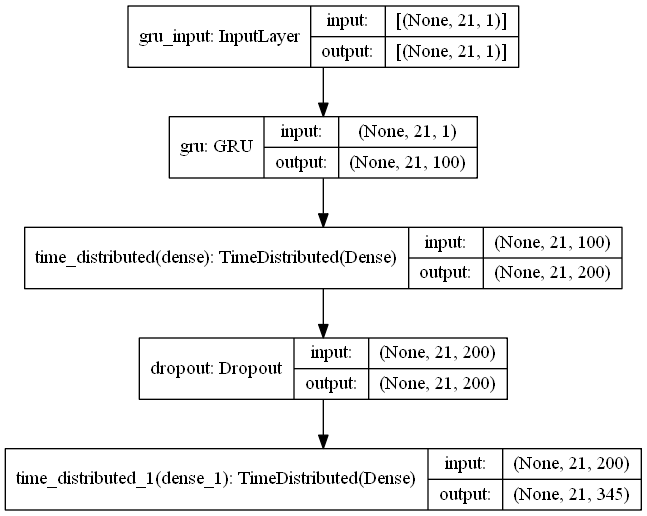

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(simple_rnn_model, to_file='simple_rnn_model.png', show_shapes=True, show_layer_names=True)

In [17]:
# Print prediction(s)
print("Prediction:")
print(logits_to_text(simple_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

print("\nCorrect Translation:")
print(french_sentences[:1])

print("\nOriginal text:")
print(english_sentences[:1])

Prediction:
new jersey est parfois calme en mois de il et est est en en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Correct Translation:
["new jersey est parfois calme pendant l' automne , et il est neigeux en avril ."]

Original text:
['new jersey is sometimes quiet during autumn , and it is snowy in april .']


### Model 2: RNN with Embedding (IMPLEMENTATION)

In [20]:
def embed_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a RNN model using word embedding on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique french words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Implement

    # Hyperparameters
    learning_rate = 0.005
    
    # TODO: Build the layers
    model = Sequential()
    model.add(Embedding(english_vocab_size, 256, input_length=input_shape[1], input_shape=input_shape[1:]))
    model.add(GRU(100, return_sequences=True))    
    model.add(TimeDistributed(Dense(200, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(french_vocab_size+1, activation='softmax'))) 

    # Compile model
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

#tests.test_embed_model(embed_model)

# TODO: Reshape the input
tmp_x = pad(preproc_english_sentences, preproc_french_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2]))

# TODO: Train the neural network
embed_rnn_model = embed_model(
    tmp_x.shape,
    preproc_french_sentences.shape[1],
    len(english_tokenizer.word_index)+1,
    len(french_tokenizer.word_index)+1)

embed_rnn_model.summary()

history = embed_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=500, epochs=10, validation_split=0.2)



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 21, 256)           51200     
_________________________________________________________________
gru_1 (GRU)                  (None, 21, 100)           107400    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 21, 200)           20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 200)           0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 21, 346)           69546     
Total params: 248,346
Trainable params: 248,346
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
221/221 [==============================] - 53s 232ms/step - loss: 1.2637 - accuracy: 0.6934 - val_loss:

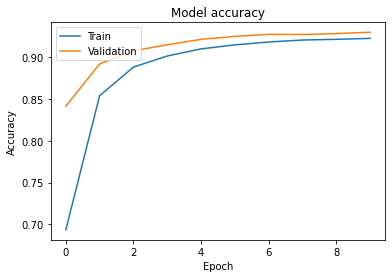

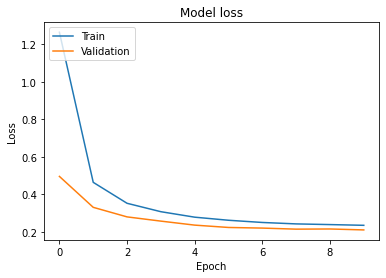

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

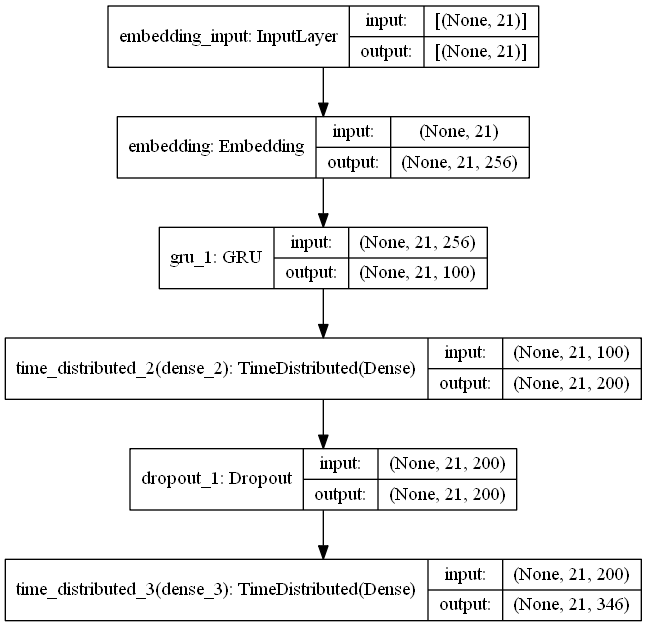

In [22]:
from tensorflow.keras.utils import plot_model
plot_model(embed_rnn_model, to_file='embed_rnn_model.png', show_shapes=True, show_layer_names=True)

In [47]:
# Print prediction(s)
print("Prediction:")

df_data = {}
for i in range(10):
    pred = logits_to_text(embed_rnn_model.predict(tmp_x[:i+1])[i], french_tokenizer)
    correct_translate = french_sentences[i]
    orig_text = english_sentences[i]
    df_data[i] = [orig_text, correct_translate, pred]
    
import pandas as pd
result = pd.DataFrame(df_data).T
result.columns = ['orig_text', 'correct_translate', 'pred_translate']
result

Prediction:


,orig_text,correct_translate,pred_translate
0,"new jersey is sometimes quiet during autumn , ...",new jersey est parfois calme pendant l' automn...,new jersey est parfois calme en l' automne et ...
1,the united states is usually chilly during jul...,les états-unis est généralement froid en juill...,les états unis est généralement froid en juill...
2,"california is usually quiet during march , and...","california est généralement calme en mars , et...",californie est généralement calme en mois et i...
3,the united states is sometimes mild during jun...,"les états-unis est parfois légère en juin , et...",les états unis est parfois doux en juin et il ...
4,"your least liked fruit is the grape , but my l...","votre moins aimé fruit est le raisin , mais mo...",votre fruit aimé des est la raisin mais mon mo...
5,"his favorite fruit is the orange , but my favo...","son fruit préféré est l'orange , mais mon préf...",son fruit préféré est la mais son préféré est ...
6,"paris is relaxing during december , but it is ...","paris est relaxant en décembre , mais il est g...",paris est relaxant en décembre mais il est gén...
7,"new jersey is busy during spring , and it is n...","new jersey est occupé au printemps , et il est...",new jersey est occupé en printemps et il est j...
8,"our least liked fruit is the lemon , but my le...","notre fruit est moins aimé le citron , mais mo...",notre fruit aimé fruit est la citron mais mon ...
9,the united states is sometimes busy during jan...,"les états-unis est parfois occupé en janvier ,...",les états unis est parfois occupé en janvier e...


### Pick words to generate a sentence to predict

In [18]:
english_tokenizer.word_index.keys()

dict_keys(['is', 'in', 'it', 'during', 'the', 'but', 'and', 'sometimes', 'usually', 'never', 'favorite', 'least', 'fruit', 'most', 'loved', 'liked', 'new', 'paris', 'india', 'united', 'states', 'california', 'jersey', 'france', 'china', 'he', 'she', 'grapefruit', 'your', 'my', 'his', 'her', 'fall', 'june', 'spring', 'january', 'winter', 'march', 'autumn', 'may', 'nice', 'september', 'july', 'april', 'november', 'summer', 'december', 'february', 'our', 'their', 'freezing', 'pleasant', 'beautiful', 'october', 'snowy', 'warm', 'cold', 'wonderful', 'dry', 'busy', 'august', 'chilly', 'rainy', 'mild', 'wet', 'relaxing', 'quiet', 'hot', 'dislikes', 'likes', 'limes', 'lemons', 'grapes', 'mangoes', 'apples', 'peaches', 'oranges', 'pears', 'strawberries', 'bananas', 'to', 'grape', 'apple', 'orange', 'lemon', 'lime', 'banana', 'mango', 'pear', 'strawberry', 'peach', 'like', 'dislike', 'they', 'that', 'i', 'we', 'you', 'animal', 'a', 'truck', 'car', 'automobile', 'was', 'next', 'go', 'driving', 'v

In [34]:
sentence = 'he likes driving to california'
sentence = [english_tokenizer.word_index[word] for word in sentence.split()]
tt = pad([sentence], max_french_sequence_length)
tt = tt.reshape((-1, preproc_french_sentences.shape[-2], 1))
predictions = embed_rnn_model.predict(tt)[0]
print(logits_to_text(predictions, french_tokenizer))
print('Correct Translation: le gusta conducir a california')

il aime voiture voiture <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Correct Translation: le gusta conducir a california


In [53]:
sentence = 'he usually drives his car'
sentence = [english_tokenizer.word_index[word] for word in sentence.split()]
tt = pad([sentence], max_french_sequence_length)
tt = tt.reshape((-1, preproc_french_sentences.shape[-2], 1))
predictions = embed_rnn_model.predict(tt)[0]
print(logits_to_text(predictions, french_tokenizer))

il est le le voiture <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [55]:
print('correct Translation: il conduit habituellement sa voiture')